In [110]:
import numpy as np
import math
import random 
import itertools
import pandas as pd
import statistics
from collections import Counter
from numpy import linalg as LA
import seaborn as sns
import scipy
from fancyimpute import SoftImpute, IterativeImputer, BiScaler
softImpute = SoftImpute(max_rank=10) #simulate data is rank 10!
biscaler = BiScaler()
import matplotlib.pyplot as plt
%matplotlib inline

## Data simulation

In [2]:
# generate the rating matrix (full)
n = 100 #users
d = 100 #movies
k = 10 #low rank
np.random.seed(0)    
U = np.random.normal(size = (n,k)) #rating from 1 to 5
V = np.random.normal(size = (d,k))

In [3]:
C = np.dot(U,V.T)  #rating has mean as 3

In [4]:
print(C.mean(),C.std(), C.min(), C.max()) #almost 3 mean, std as 3

-0.010252226112908549 3.0192075810725325 -13.289932086409593 12.539758417329221


In [5]:
thresholds = [-np.inf,-6., -2.,  2.,  6., np.inf]
thresholds

[-inf, -6.0, -2.0, 2.0, 6.0, inf]

In [6]:
# generate rating matrix (low rank as 10), with all the values from 1 to 5
y = np.zeros((100,100))
for i in range(len(thresholds)-1):
    mask = ((C > thresholds[i]) & (C <= thresholds[i+1]))
    y[mask] = i+1

In [7]:
#check low-rank assumption
u_y, s_y, vh_y = np.linalg.svd(y)

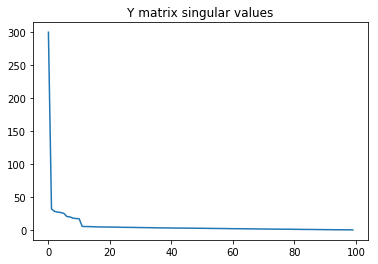

In [8]:
# plot for s-values of y_NMAR_softimpute concatenated matrix
plt.plot(range(len(s_y)), s_y)
plt.title('Y matrix singular values')
plt.show()

In [9]:
# MCAR
np.random.seed(100)    
miss_indices = random.sample(range(100*100), 3000)
y_flat = np.copy(y).flatten()
y_flat[miss_indices] = np.nan
y_mcar = y_flat.reshape(100,100)

In [10]:
np.isnan(y_mcar).sum()/np.prod(y_mcar.shape)

0.3

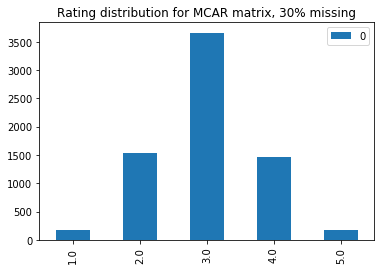

In [11]:
#visualize the observed entries
rating_counts = Counter(y_mcar[~np.isnan(y_mcar)])
mcar_counts = pd.DataFrame.from_dict(rating_counts, orient='index').sort_index()
mcar_counts.plot(kind='bar', title='Rating distribution for MCAR matrix, 30% missing')  # arguments are passed to np.histogram

In [12]:
# MAR: when same movie ratings decreases three times, become missing (missingness is embedded in the data itself)
# more popular movies got to be rated more, less popular movies would not be recommended
y_mar = np.copy(y)
col_idx_low = np.where(np.mean(y[0:10,:], axis=0) <= np.mean(y[0:10,:]))[0] # get the movies have lower mean rating from first 20% entries, subsample in the later 80% with different likelihood
col_idx_high = np.where(np.mean(y[0:10,:], axis=0) > np.mean(y[0:10,:]))[0] # get the movies have higher mean rating from first 20% entries, subsample in the later 80% with different likelihood
for col in col_idx_low:
    row_miss_low = int(100*0.35)
    row_idx = np.random.choice(np.arange(20,100), row_miss_low, replace=False) 
    y_mar[row_idx, col] = np.nan
for col in col_idx_high:
    row_miss_high = int( (3000-row_miss_low*len(col_idx_low))/len(col_idx_high) )
    row_idx = np.random.choice(np.arange(20,100), row_miss_high, replace=False) 
    y_mar[row_idx, col] = np.nan
#use first 20% as observed values, calculate column mean (movie popularity) => high

In [13]:
#calculate the percentage of missing
np.isnan(y_mar).sum()/np.prod(y_mar.shape)

0.298

In [14]:
rating_counts_mar = Counter(y_mar[~np.isnan(y_mar)])
mar_counts = pd.DataFrame.from_dict(rating_counts_mar, orient='index').sort_index()

In [15]:
# NMAR: more popular movies tend to be rate more, and use the score itself to model missing mechanism
# missing is determined by another distribution/mechanism independent of the observed dataset
# can use a logistic regression (probability of being missing) to mimic a cut-off effect
def logit(x):
    return 1/(1+np.exp(-x))

In [16]:
mask_high = np.where(y >= 4, 1,-3)
mask_high

array([[ 1,  1,  1, ...,  1, -3,  1],
       [ 1,  1, -3, ..., -3, -3,  1],
       [-3,  1,  1, ..., -3, -3, -3],
       ...,
       [ 1,  1,  1, ..., -3, -3, -3],
       [-3, -3, -3, ..., -3, -3, -3],
       [-3, -3, -3, ..., -3, -3, -3]])

In [17]:
y_p = logit(np.multiply(y,mask_high)+np.dot(U,V.T)) #ratings 4 and 5 are likely to be seen more

In [18]:
y_p

array([[9.98130840e-01, 9.98440730e-01, 9.97572975e-01, ...,
        9.98333698e-01, 2.03605126e-04, 9.99588712e-01],
       [9.97972927e-01, 9.98659815e-01, 2.39606324e-04, ...,
        2.76617700e-04, 5.04831747e-05, 9.99109601e-01],
       [8.16059890e-05, 9.99041725e-01, 9.99788858e-01, ...,
        2.57626908e-05, 5.44719458e-04, 6.99952034e-06],
       ...,
       [9.98001924e-01, 9.99789495e-01, 9.99438250e-01, ...,
        1.87044701e-05, 3.11995659e-05, 2.96498469e-05],
       [2.84069697e-05, 1.68919911e-04, 3.17046813e-05, ...,
        1.86840423e-04, 1.04995126e-04, 3.31316100e-04],
       [2.26888121e-04, 4.62286231e-05, 1.03030869e-04, ...,
        6.12529311e-04, 1.40248479e-04, 3.17397842e-04]])

In [19]:
#use threshold as cutoff value (any thing above below this value will be set to missing - lower ratings less seen
threshold = np.percentile(y_p, 30) #value at 1-24.96% percentile
y_nmar = np.copy(y)
y_nmar[y_p < threshold] = np.nan                

In [20]:
np.isnan(y_nmar).sum()/np.prod(y_nmar.shape)

0.3

In [21]:
y_nmar

array([[ 4.,  4.,  4., ...,  4.,  2.,  4.],
       [ 4.,  4.,  3., ...,  3., nan,  4.],
       [ 3.,  4.,  4., ..., nan,  3., nan],
       ...,
       [ 4.,  4.,  4., ..., nan, nan, nan],
       [nan,  3., nan, ...,  3.,  2.,  2.],
       [ 3., nan,  3., ...,  3.,  3.,  3.]])

In [89]:
mask = np.isnan(y_nmar).astype(int)
y_input = np.concatenate((y, mask), axis=1)

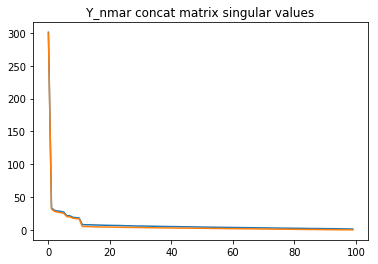

In [92]:
u_yc, s_yc, vh_yc = np.linalg.svd(y_input)
plt.plot(range(len(s_yc)), s_yc)
plt.plot(range(len(s_y)), s_y)
plt.title('Y_nmar concat matrix singular values')
plt.show()

In [100]:
print("original y     ","y+mask")
print(np.c_[s_y[0:10], s_yc[0:10]])

original y      y+mask
[[299.41419028 300.95674828]
 [ 31.75137347  33.61944141]
 [ 28.10700943  29.60942065]
 [ 26.96691603  28.80986153]
 [ 26.35276376  28.19970894]
 [ 25.13741726  27.2176761 ]
 [ 20.29408502  21.58094499]
 [ 19.69889561  21.45562492]
 [ 17.82515465  19.23862052]
 [ 17.2313745   18.70542572]]


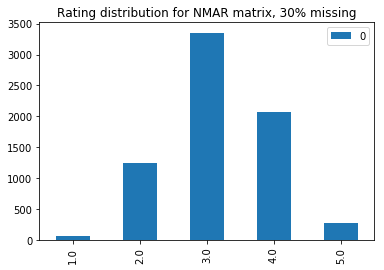

In [22]:
#visualize the observed entries
rating_counts_nmar = Counter(y_nmar[~np.isnan(y_nmar)])
nmar_counts = pd.DataFrame.from_dict(rating_counts_nmar, orient='index').sort_index()
nmar_counts.plot(kind='bar', title='Rating distribution for NMAR matrix, 30% missing')  # arguments are passed to np.histogram

In [23]:
df_3 = pd.concat([mcar_counts,mar_counts,nmar_counts],axis=1)
df_3.columns = ['MCAR', 'MAR','NMAR']

/Users/nhuang37/anaconda3/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


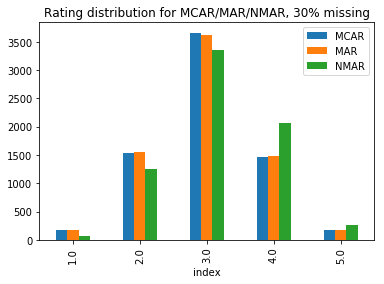

In [24]:
df_3.reset_index().plot(x='index', y=['MCAR', 'MAR','NMAR'], kind="bar",title='Rating distribution for MCAR/MAR/NMAR, 30% missing')

## Algorithms
- nuclear norm minimization (softimpute)
- multiple imputation
- softimpute + mask

** Evaluation: test error = (yfill - y)^2/||y|| on the missing entries & normalize different missing entries)

### Softimpute

In [25]:
# standardize data
y_mcar_s = biscaler.fit_transform(y_mcar)  #standardized to row/col with mean 0 and var =1
#y_normalized = np.copy(y_m)

[BiScaler] Initial log residual value = 7.549703
[BiScaler] Iter 1: log residual = -2.178436, log improvement ratio=9.728139
[BiScaler] Iter 2: log residual = -6.321051, log improvement ratio=4.142615
[BiScaler] Iter 3: log residual = -9.974026, log improvement ratio=3.652975
[BiScaler] Iter 4: log residual = -13.335021, log improvement ratio=3.360995
[BiScaler] Iter 5: log residual = -16.537982, log improvement ratio=3.202961
[BiScaler] Iter 6: log residual = -19.644236, log improvement ratio=3.106254
[BiScaler] Iter 7: log residual = -22.688666, log improvement ratio=3.044430
[BiScaler] Iter 8: log residual = -25.693886, log improvement ratio=3.005220
[BiScaler] Iter 9: log residual = -28.674483, log improvement ratio=2.980597
[BiScaler] Iter 10: log residual = -31.639692, log improvement ratio=2.965209
[BiScaler] Iter 11: log residual = -34.595246, log improvement ratio=2.955554
[BiScaler] Iter 12: log residual = -37.544655, log improvement ratio=2.949409
[BiScaler] Iter 13: log res

In [26]:
# Softimput on MCAR matrix
y_MCAR_softimpute = softImpute.fit_transform(y_mcar_s)

[SoftImpute] Max Singular Value of X_init = 25.951397
[SoftImpute] Iter 1: observed MAE=0.391464 rank=10
[SoftImpute] Iter 2: observed MAE=0.330744 rank=10
[SoftImpute] Iter 3: observed MAE=0.314856 rank=10
[SoftImpute] Iter 4: observed MAE=0.309511 rank=10
[SoftImpute] Iter 5: observed MAE=0.307317 rank=10
[SoftImpute] Iter 6: observed MAE=0.306310 rank=10
[SoftImpute] Iter 7: observed MAE=0.305814 rank=10
[SoftImpute] Iter 8: observed MAE=0.305530 rank=10
[SoftImpute] Iter 9: observed MAE=0.305365 rank=10
[SoftImpute] Iter 10: observed MAE=0.305261 rank=10
[SoftImpute] Iter 11: observed MAE=0.305192 rank=10
[SoftImpute] Iter 12: observed MAE=0.305144 rank=10
[SoftImpute] Iter 13: observed MAE=0.305111 rank=10
[SoftImpute] Iter 14: observed MAE=0.305088 rank=10
[SoftImpute] Iter 15: observed MAE=0.305071 rank=10
[SoftImpute] Iter 16: observed MAE=0.305059 rank=10
[SoftImpute] Iter 17: observed MAE=0.305050 rank=10
[SoftImpute] Stopped after iteration 17 for lambda=0.519028


In [27]:
# recover the original matrix
y_MCAR_softimpute = softImpute.fit_transform(y_mcar_s)
y_MCAR_original = biscaler.inverse_transform(y_MCAR_softimpute)

[SoftImpute] Max Singular Value of X_init = 25.951397
[SoftImpute] Iter 1: observed MAE=0.391464 rank=10
[SoftImpute] Iter 2: observed MAE=0.330744 rank=10
[SoftImpute] Iter 3: observed MAE=0.314856 rank=10
[SoftImpute] Iter 4: observed MAE=0.309511 rank=10
[SoftImpute] Iter 5: observed MAE=0.307317 rank=10
[SoftImpute] Iter 6: observed MAE=0.306310 rank=10
[SoftImpute] Iter 7: observed MAE=0.305814 rank=10
[SoftImpute] Iter 8: observed MAE=0.305530 rank=10
[SoftImpute] Iter 9: observed MAE=0.305365 rank=10
[SoftImpute] Iter 10: observed MAE=0.305261 rank=10
[SoftImpute] Iter 11: observed MAE=0.305192 rank=10
[SoftImpute] Iter 12: observed MAE=0.305144 rank=10
[SoftImpute] Iter 13: observed MAE=0.305111 rank=10
[SoftImpute] Iter 14: observed MAE=0.305088 rank=10
[SoftImpute] Iter 15: observed MAE=0.305071 rank=10
[SoftImpute] Iter 16: observed MAE=0.305059 rank=10
[SoftImpute] Iter 17: observed MAE=0.305050 rank=10
[SoftImpute] Stopped after iteration 17 for lambda=0.519028


In [28]:
#softImpute_mse = (( (y_MCAR_softimpute[np.isnan(y_mcar)] - y_normalized[np.isnan(y_mcar)])/ y_normalized[np.isnan(y_mcar)])  ** 2).mean()
y_MCAR_original = biscaler.inverse_transform(y_MCAR_softimpute)
test_error = ( LA.norm(y[np.isnan(y_mcar)] - y_MCAR_original[np.isnan(y_mcar)])  /  LA.norm(y[np.isnan(y_mcar)])) **2
print("SoftImpute MSE on MCAR: %f" % test_error)

SoftImpute MSE on MCAR: 0.014138


In [29]:
# Softimpute on MAR matrix
y_mar_s = biscaler.fit_transform(y_mar)  #standardized to row/col with mean 0 and var =1
y_MAR_softimpute = softImpute.fit_transform(y_mar_s)

[BiScaler] Initial log residual value = 7.546990
[BiScaler] Iter 1: log residual = -1.716162, log improvement ratio=9.263152
[BiScaler] Iter 2: log residual = -5.363344, log improvement ratio=3.647181
[BiScaler] Iter 3: log residual = -8.695587, log improvement ratio=3.332244
[BiScaler] Iter 4: log residual = -11.859191, log improvement ratio=3.163603
[BiScaler] Iter 5: log residual = -14.960611, log improvement ratio=3.101421
[BiScaler] Iter 6: log residual = -18.025580, log improvement ratio=3.064968
[BiScaler] Iter 7: log residual = -21.064763, log improvement ratio=3.039183
[BiScaler] Iter 8: log residual = -24.083756, log improvement ratio=3.018993
[BiScaler] Iter 9: log residual = -27.086389, log improvement ratio=3.002633
[BiScaler] Iter 10: log residual = -30.075686, log improvement ratio=2.989297
[BiScaler] Iter 11: log residual = -33.054131, log improvement ratio=2.978445
[BiScaler] Iter 12: log residual = -36.023765, log improvement ratio=2.969634
[BiScaler] Iter 13: log res

In [30]:
# recover the original matrix
y_MAR_original = biscaler.inverse_transform(y_MAR_softimpute)
#compute mse
test_error = ( LA.norm(y[np.isnan(y_mar)] - y_MAR_original[np.isnan(y_mar)])  /  LA.norm(y[np.isnan(y_mar)])) **2
print("SoftImpute MSE on MAR: %f" % test_error)

SoftImpute MSE on MAR: 0.014195


In [31]:
# Softimpute on NMAR matrix
y_nmar_s = biscaler.fit_transform(y_nmar)  #standardized to row/col with mean 0 and var =1
y_NMAR_softimpute = softImpute.fit_transform(y_nmar)

[BiScaler] Initial log residual value = 7.652939
[BiScaler] Iter 1: log residual = -2.526752, log improvement ratio=10.179691
[BiScaler] Iter 2: log residual = -6.277015, log improvement ratio=3.750264
[BiScaler] Iter 3: log residual = -9.589859, log improvement ratio=3.312843
[BiScaler] Iter 4: log residual = -12.643966, log improvement ratio=3.054108
[BiScaler] Iter 5: log residual = -15.586307, log improvement ratio=2.942340
[BiScaler] Iter 6: log residual = -18.492052, log improvement ratio=2.905745
[BiScaler] Iter 7: log residual = -21.385628, log improvement ratio=2.893576
[BiScaler] Iter 8: log residual = -24.274532, log improvement ratio=2.888904
[BiScaler] Iter 9: log residual = -27.160627, log improvement ratio=2.886095
[BiScaler] Iter 10: log residual = -30.044037, log improvement ratio=2.883410
[BiScaler] Iter 11: log residual = -32.924536, log improvement ratio=2.880498
[BiScaler] Iter 12: log residual = -35.801983, log improvement ratio=2.877447
[BiScaler] Iter 13: log re

In [32]:
# recover the original matrix
y_NMAR_original = biscaler.inverse_transform(y_NMAR_softimpute)
#softImpute_mse = ( (y_NMAR_original[np.isnan(y_nmar)] - y_m[np.isnan(y_nmar)])** 2 / LA.norm(y_m[np.isnan(y_nmar)])).mean()
test_error = ( LA.norm(y[np.isnan(y_nmar)] - y_NMAR_original[np.isnan(y_nmar)])  /  LA.norm(y[np.isnan(y_nmar)])) **2
print("SoftImpute MSE on NMAR: %f" % test_error)

SoftImpute MSE on NMAR: 0.986587


- restric to rank 10, NMAR has worse performance using softimpute (even with double standardization)

### softImpute with mask concatenation (NMAR)

In [33]:
# function to fit softimpute and compute test error
def soft_mask(y_miss, y_original):
    ncol = np.shape(y_original)[1]
    mask = np.isnan(y_miss).astype(int)
    y_input_s = biscaler.fit_transform(y_miss) 
    y_input = np.concatenate((y_input_s, mask), axis=1)
    y_MCAR_softimpute = softImpute.fit_transform(y_input)
    y_MCAR_original = biscaler.inverse_transform(y_MCAR_softimpute[:,0:ncol])
    test_error = ( LA.norm(y_original[np.isnan(y_miss)] - y_MCAR_original[np.isnan(y_miss)])  /  LA.norm(y_original[np.isnan(y_miss)])) **2
    return test_error, y_MCAR_softimpute


In [34]:
test_error_mcar,y_MCAR_soft = soft_mask(y_mcar, y)
test_error_mar,y_MAR_soft= soft_mask(y_mar, y)
test_error_nmar,y_NMAR_soft= soft_mask(y_nmar, y)


[BiScaler] Initial log residual value = 7.549703
[BiScaler] Iter 1: log residual = -2.178436, log improvement ratio=9.728139
[BiScaler] Iter 2: log residual = -6.321051, log improvement ratio=4.142615
[BiScaler] Iter 3: log residual = -9.974026, log improvement ratio=3.652975
[BiScaler] Iter 4: log residual = -13.335021, log improvement ratio=3.360995
[BiScaler] Iter 5: log residual = -16.537982, log improvement ratio=3.202961
[BiScaler] Iter 6: log residual = -19.644236, log improvement ratio=3.106254
[BiScaler] Iter 7: log residual = -22.688666, log improvement ratio=3.044430
[BiScaler] Iter 8: log residual = -25.693886, log improvement ratio=3.005220
[BiScaler] Iter 9: log residual = -28.674483, log improvement ratio=2.980597
[BiScaler] Iter 10: log residual = -31.639692, log improvement ratio=2.965209
[BiScaler] Iter 11: log residual = -34.595246, log improvement ratio=2.955554
[BiScaler] Iter 12: log residual = -37.544655, log improvement ratio=2.949409
[BiScaler] Iter 13: log res

[SoftImpute] Iter 8: observed MAE=0.301333 rank=10
[SoftImpute] Iter 9: observed MAE=0.300291 rank=10
[SoftImpute] Iter 10: observed MAE=0.299563 rank=10
[SoftImpute] Iter 11: observed MAE=0.299032 rank=10
[SoftImpute] Iter 12: observed MAE=0.298638 rank=10
[SoftImpute] Iter 13: observed MAE=0.298347 rank=10
[SoftImpute] Iter 14: observed MAE=0.298127 rank=10
[SoftImpute] Iter 15: observed MAE=0.297960 rank=10
[SoftImpute] Iter 16: observed MAE=0.297834 rank=10
[SoftImpute] Iter 17: observed MAE=0.297738 rank=10
[SoftImpute] Iter 18: observed MAE=0.297663 rank=10
[SoftImpute] Iter 19: observed MAE=0.297604 rank=10
[SoftImpute] Iter 20: observed MAE=0.297557 rank=10
[SoftImpute] Iter 21: observed MAE=0.297519 rank=10
[SoftImpute] Iter 22: observed MAE=0.297489 rank=10
[SoftImpute] Iter 23: observed MAE=0.297464 rank=10
[SoftImpute] Iter 24: observed MAE=0.297444 rank=10
[SoftImpute] Iter 25: observed MAE=0.297427 rank=10
[SoftImpute] Iter 26: observed MAE=0.297414 rank=10
[SoftImpute] S

In [35]:
print("concat_MCAR: ", test_error_mcar)
print("concat_MAR: ", test_error_mar)
print("concat_NMAR: ", test_error_nmar)

concat_MCAR:  0.01898716488513737
concat_MAR:  0.01844161087124103
concat_NMAR:  0.03746022906621001


In [36]:
#check low-rank assumption
u_nmar, s_nmar, vh_nmar = np.linalg.svd(y_NMAR_softimpute)

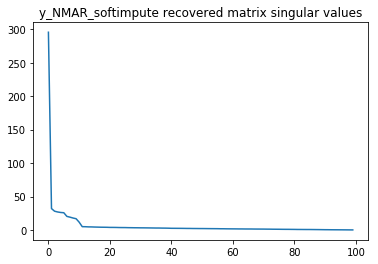

In [37]:
# plot for s-values of y_NMAR_softimpute
plt.plot(range(len(s_nmar)), s_nmar)
plt.title('y_NMAR_softimpute recovered matrix singular values')
plt.show()

In [38]:
u_nmar_con, s_nmar_con, vh_nmar_con = np.linalg.svd(np.concatenate((y_NMAR_soft, mask),axis=1))

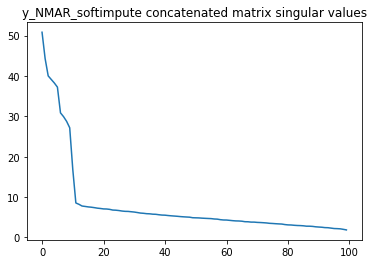

In [39]:
# plot for s-values of y_NMAR_softimpute concatenated matrix
plt.plot(range(len(s_nmar_con)), s_nmar_con)
plt.title('y_NMAR_softimpute concatenated matrix singular values')
plt.show()

- after concatenating the mask, NMAR has much better performance (same par as MCAR & MAR)

### Multiple imputation

In [40]:
import numpy as np
from fancyimpute import IterativeImputer

#MCAR
n_imputations = 20
XY_completed = []
for i in range(n_imputations):
    imputer = IterativeImputer(n_iter=5, sample_posterior=True, random_state=i)
    XY_completed.append(imputer.fit_transform(y_mcar))

MCAR_completed_mean = np.mean(XY_completed, 0) #mean of the imputed matrix
MCAR_completed_std = np.std(XY_completed, 0)

In [41]:
#MM_mse = ((MCAR_completed_mean[np.isnan(y_mcar)] - y_normalized[np.isnan(y_mcar)])  ** 2 /  LA.norm(y_normalized[np.isnan(y_mcar)])).mean()
test_error = ( LA.norm(y[np.isnan(y_mcar)] - MCAR_completed_mean[np.isnan(y_mcar)])  /  LA.norm(y[np.isnan(y_mcar)])) **2
print("Multiple Imputation test error on MCAR: %f" % test_error)

Multiple Imputation test error on MCAR: 0.023685


In [42]:
#MAR
n_imputations = 20
XY_completed = []
for i in range(n_imputations):
    imputer = IterativeImputer(n_iter=5, sample_posterior=True, random_state=i)
    XY_completed.append(imputer.fit_transform(y_mar))

MAR_completed_mean = np.mean(XY_completed, 0) #mean of the imputed matrix
MAR_completed_std = np.std(XY_completed, 0)
test_error = ( LA.norm(y[np.isnan(y_mar)] - MAR_completed_mean[np.isnan(y_mar)])  /  LA.norm(y[np.isnan(y_mar)])) **2
print("Multiple Imputation test error on MAR: %f" % test_error)

Multiple Imputation test error on MAR: 0.023505


In [43]:
#NMAR
n_imputations = 20
XY_completed = []
for i in range(n_imputations):
    imputer = IterativeImputer(n_iter=5, sample_posterior=True, random_state=i)
    XY_completed.append(imputer.fit_transform(y_nmar))

NMAR_completed_mean = np.mean(XY_completed, 0) #mean of the imputed matrix
NMAR_completed_std = np.std(XY_completed, 0)
test_error = ( LA.norm(y[np.isnan(y_nmar)] - NMAR_completed_mean[np.isnan(y_nmar)])  /  LA.norm(y[np.isnan(y_nmar)])) **2
print("Multiple Imputation test error on NMAR: %f" % test_error)

Multiple Imputation test error on NMAR: 0.026509


In [72]:
# include missingness param for MI (use concatednated data)
    #MI for NMAR
ncol = np.shape(y)[1]
mask = np.isnan(y_nmar).astype(int)
y_input = np.concatenate((y_nmar, mask), axis=1)

n_imputations = 20
XY_completed = []
for i in range(n_imputations):
    imputer = IterativeImputer(n_iter=10, sample_posterior=True, random_state=i)
    XY_completed.append(imputer.fit_transform(y_input))

NMAR_completed_mean = np.mean(XY_completed, 0) #mean of the imputed matrix

In [73]:
len(y_con[np.isnan(y_input)]), len(y[np.isnan(y_nmar)])

(3000, 3000)

In [74]:
y_con = np.concatenate((y, mask), axis=1)
test_error_MI_mask = ( LA.norm(y_con[np.isnan(y_input)] - NMAR_completed_mean[np.isnan(y_input)])  /  LA.norm(y_con[np.isnan(y_input)])) **2
print(test_error_MI_mask)

0.03701434720785166


- Multiple imputation (MICE) has similar performance for MCAR, MAR, NMAR data!

## missing percentage 

In [137]:
# % = 10%, 20%, 30%, 40% 50%
NMAR_errs = []; NMAR_con_errs = []; NMAR_MI_errs = []

for k in [0.1, 0.15, 0.2, 0.25,0.3]:
    # NMAR:
    mask_high = np.where(y >= 4, 1,-3)
    y_p = logit(np.multiply(y,mask_high)+np.dot(U,V.T)) #ratings 4 and 5 are likely to be seen more
    threshold = np.percentile(y_p, 100*k) #value at k percentile
    y_nmar = np.copy(y)
    y_nmar[y_p < threshold] = np.nan #cut-off effect
    #softimpute
    y_nmar_s = biscaler.fit_transform(y_nmar)  #standardized to row/col with mean 0 and var =1
    y_NMAR_softimpute = softImpute.fit_transform(y_nmar)
    y_NMAR_original = biscaler.inverse_transform(y_NMAR_softimpute)
    test_error = ( LA.norm(y[np.isnan(y_nmar)] - y_NMAR_original[np.isnan(y_nmar)])  /  LA.norm(y[np.isnan(y_nmar)])) **2
    NMAR_errs.append(test_error)
    
    #concat mask
    test_error_nmar,y_NMAR_soft= soft_mask(y_nmar, y)
    NMAR_con_errs.append(test_error_nmar)
    
    #MI
    n_imputations = 10
    XY_completed = []
    for i in range(n_imputations):
        imputer = IterativeImputer(n_iter=5, sample_posterior=True, random_state=i)
        XY_completed.append(imputer.fit_transform(y_nmar))

    NMAR_completed_mean = np.mean(XY_completed, 0) #mean of the imputed matrix
    test_error_MI = ( LA.norm(y[np.isnan(y_nmar)] - NMAR_completed_mean[np.isnan(y_nmar)])  /  LA.norm(y[np.isnan(y_nmar)])) **2
    NMAR_MI_errs.append(test_error_MI)

[BiScaler] Initial log residual value = 7.587201
[BiScaler] Iter 1: log residual = -2.362382, log improvement ratio=9.949583
[BiScaler] Iter 2: log residual = -6.596271, log improvement ratio=4.233888
[BiScaler] Iter 3: log residual = -10.358719, log improvement ratio=3.762448
[BiScaler] Iter 4: log residual = -13.805795, log improvement ratio=3.447077
[BiScaler] Iter 5: log residual = -17.114491, log improvement ratio=3.308696
[BiScaler] Iter 6: log residual = -20.370887, log improvement ratio=3.256396
[BiScaler] Iter 7: log residual = -23.609699, log improvement ratio=3.238812
[BiScaler] Iter 8: log residual = -26.844699, log improvement ratio=3.235001
[BiScaler] Iter 9: log residual = -30.081274, log improvement ratio=3.236574
[BiScaler] Iter 10: log residual = -33.321393, log improvement ratio=3.240120
[BiScaler] Iter 11: log residual = -36.565621, log improvement ratio=3.244227
[BiScaler] Iter 12: log residual = -39.813935, log improvement ratio=3.248315
[BiScaler] Iter 13: log re

[BiScaler] Initial log residual value = 7.610806
[BiScaler] Iter 1: log residual = -2.402561, log improvement ratio=10.013368
[BiScaler] Iter 2: log residual = -6.371284, log improvement ratio=3.968722
[BiScaler] Iter 3: log residual = -9.921234, log improvement ratio=3.549950
[BiScaler] Iter 4: log residual = -13.147890, log improvement ratio=3.226656
[BiScaler] Iter 5: log residual = -16.240947, log improvement ratio=3.093057
[BiScaler] Iter 6: log residual = -19.302296, log improvement ratio=3.061350
[BiScaler] Iter 7: log residual = -22.362904, log improvement ratio=3.060608
[BiScaler] Iter 8: log residual = -25.429615, log improvement ratio=3.066711
[BiScaler] Iter 9: log residual = -28.502696, log improvement ratio=3.073080
[BiScaler] Iter 10: log residual = -31.580849, log improvement ratio=3.078153
[BiScaler] Iter 11: log residual = -34.662604, log improvement ratio=3.081756
[BiScaler] Iter 12: log residual = -37.746705, log improvement ratio=3.084101
[BiScaler] Iter 13: log re

[BiScaler] Iter 16: log residual = -48.985277, log improvement ratio=2.987150
[BiScaler] Iter 17: log residual = -51.971702, log improvement ratio=2.986426
[BiScaler] Iter 18: log residual = -54.957207, log improvement ratio=2.985504
[BiScaler] Iter 19: log residual = -57.942428, log improvement ratio=2.985221
[BiScaler] Iter 20: log residual = -60.906340, log improvement ratio=2.963912
[BiScaler] Iter 21: log residual = -63.629502, log improvement ratio=2.723162
[BiScaler] Iter 22: log residual = -64.416896, log improvement ratio=0.787395
[BiScaler] Iter 23: log residual = -64.920841, log improvement ratio=0.503945
[BiScaler] Iter 24: log residual = -64.460654, log improvement ratio=-0.460187
[SoftImpute] Max Singular Value of X_init = 28.630573
[SoftImpute] Iter 1: observed MAE=0.355796 rank=10
[SoftImpute] Iter 2: observed MAE=0.323237 rank=10
[SoftImpute] Iter 3: observed MAE=0.308696 rank=10
[SoftImpute] Iter 4: observed MAE=0.301393 rank=10
[SoftImpute] Iter 5: observed MAE=0.297

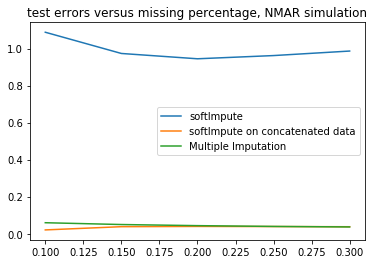

In [138]:
# plot for test_error, test_error_concat w.r.t missing percentage, NMAR simulation
plt.plot( [0.1, 0.15, 0.2, 0.25,0.3],NMAR_errs, [0.1, 0.15, 0.2, 0.25,0.3], NMAR_con_errs)
plt.plot( [0.1, 0.15, 0.2, 0.25,0.3],NMAR_MI_errs)       
#plt.axhline(y=0.026509, color='r', linestyle='--')
plt.title('test errors versus missing percentage, NMAR simulation')
plt.legend(['softImpute','softImpute on concatenated data','Multiple Imputation'], loc='best')
plt.show()

In [136]:
NMAR_errs

[1.0881849493972766,
 0.97351033992666,
 0.9448256558807486,
 0.9621759474851656,
 0.9865869643245726]

In [46]:
def soft(y_miss,y):
    y_s = biscaler.fit_transform(y_miss)  #standardized to row/col with mean 0 and var =1
    y_softimpute = softImpute.fit_transform(y_s)
    y_original = biscaler.inverse_transform(y_softimpute)
    test_error = ( LA.norm(y[np.isnan(y_miss)] - y_original[np.isnan(y_miss)])  /  LA.norm(y[np.isnan(y_miss)])) **2
    return test_error

In [139]:
def MI(y_miss, y):
    n_imputations = 10
    XY_completed = []
    for i in range(n_imputations):
        imputer = IterativeImputer(n_iter=5, sample_posterior=True, random_state=i)
        XY_completed.append(imputer.fit_transform(y_miss))
    completed_mean = np.mean(XY_completed, 0) #mean of the imputed matrix
    test_error_MI = ( LA.norm(y[np.isnan(y_miss)] - completed_mean[np.isnan(y_miss)])  /  LA.norm(y[np.isnan(y_miss)])) **2
    return test_error_MI


In [140]:
MCAR_errs = []; MCAR_con_errs = []; MCAR_MI_errs = []
MAR_errs = []; MAR_con_errs = []; MAR_MI_errs = []
for k in [0.1, 0.15, 0.2, 0.25,0.3]:
    # MCAR
    np.random.seed(100)    
    miss_indices = random.sample(range(100*100), int(10000*k))
    y_flat = np.copy(y).flatten()
    y_flat[miss_indices] = np.nan
    y_mcar = y_flat.reshape(100,100)    
    # MAR: subsample ratings <=3 to have missing values
    y_mar = np.copy(y)
    col_idx_low = np.where(np.mean(y[0:10,:], axis=0) <= np.mean(y[0:10,:]))[0] # get the movies have lower mean rating from first 20% entries, subsample in the later 80% with different likelihood
    col_idx_high = np.where(np.mean(y[0:10,:], axis=0) > np.mean(y[0:10,:]))[0] # get the movies have higher mean rating from first 20% entries, subsample in the later 80% with different likelihood
    for col in col_idx_low:
        row_miss_low = int(100* (k+0.05))
        row_idx = np.random.choice(np.arange(10,100), row_miss_low, replace=False) 
        y_mar[row_idx, col] = np.nan
    for col in col_idx_high:
        row_miss_high = int( (10000*k-row_miss_low*len(col_idx_low))/len(col_idx_high) )
        row_idx = np.random.choice(np.arange(10,100), row_miss_high, replace=False) 
        y_mar[row_idx, col] = np.nan
    #softimpute
    test_mcar = soft(y_mcar, y)
    MCAR_errs.append(test_mcar)
    test_mar = soft(y_mar,y)
    MAR_errs.append(test_mar)
    #concat mask
    test_error_mcar,y_MCAR_soft= soft_mask(y_mcar, y)
    MCAR_con_errs.append(test_error_mcar)
    test_error_mar,y_MAR_soft= soft_mask(y_mar, y)
    MAR_con_errs.append(test_error_mar)    
    #MI
    test_mcar_MI = MI(y_mcar, y)
    MCAR_MI_errs.append(test_mcar_MI)
    test_mar_MI = MI(y_mar, y)
    MAR_MI_errs.append(test_mar_MI)
    

[BiScaler] Initial log residual value = 7.550494
[BiScaler] Iter 1: log residual = -2.243017, log improvement ratio=9.793511
[BiScaler] Iter 2: log residual = -6.475402, log improvement ratio=4.232384
[BiScaler] Iter 3: log residual = -10.304902, log improvement ratio=3.829500
[BiScaler] Iter 4: log residual = -13.966111, log improvement ratio=3.661209
[BiScaler] Iter 5: log residual = -17.550173, log improvement ratio=3.584062
[BiScaler] Iter 6: log residual = -21.089686, log improvement ratio=3.539513
[BiScaler] Iter 7: log residual = -24.600026, log improvement ratio=3.510340
[BiScaler] Iter 8: log residual = -28.089962, log improvement ratio=3.489936
[BiScaler] Iter 9: log residual = -31.564964, log improvement ratio=3.475001
[BiScaler] Iter 10: log residual = -35.028539, log improvement ratio=3.463575
[BiScaler] Iter 11: log residual = -38.482974, log improvement ratio=3.454435
[BiScaler] Iter 12: log residual = -41.929793, log improvement ratio=3.446819
[BiScaler] Iter 13: log re

[BiScaler] Initial log residual value = 7.549419
[BiScaler] Iter 1: log residual = -2.187712, log improvement ratio=9.737131
[BiScaler] Iter 2: log residual = -6.283656, log improvement ratio=4.095944
[BiScaler] Iter 3: log residual = -9.966743, log improvement ratio=3.683087
[BiScaler] Iter 4: log residual = -13.462722, log improvement ratio=3.495979
[BiScaler] Iter 5: log residual = -16.873836, log improvement ratio=3.411114
[BiScaler] Iter 6: log residual = -20.237452, log improvement ratio=3.363616
[BiScaler] Iter 7: log residual = -23.572036, log improvement ratio=3.334584
[BiScaler] Iter 8: log residual = -26.887763, log improvement ratio=3.315727
[BiScaler] Iter 9: log residual = -30.190536, log improvement ratio=3.302773
[BiScaler] Iter 10: log residual = -33.483928, log improvement ratio=3.293393
[BiScaler] Iter 11: log residual = -36.770213, log improvement ratio=3.286284
[BiScaler] Iter 12: log residual = -40.050904, log improvement ratio=3.280691
[BiScaler] Iter 13: log res

[BiScaler] Iter 16: log residual = -53.411142, log improvement ratio=3.222816
[BiScaler] Iter 17: log residual = -56.627821, log improvement ratio=3.216679
[BiScaler] Iter 18: log residual = -59.862260, log improvement ratio=3.234439
[BiScaler] Iter 19: log residual = -62.878357, log improvement ratio=3.016097
[BiScaler] Iter 20: log residual = -64.691324, log improvement ratio=1.812967
[BiScaler] Iter 21: log residual = -64.380480, log improvement ratio=-0.310844
[SoftImpute] Max Singular Value of X_init = 31.719927
[SoftImpute] Iter 1: observed MAE=0.272883 rank=10
[SoftImpute] Iter 2: observed MAE=0.259956 rank=10
[SoftImpute] Iter 3: observed MAE=0.257569 rank=10
[SoftImpute] Iter 4: observed MAE=0.256996 rank=10
[SoftImpute] Iter 5: observed MAE=0.256872 rank=10
[SoftImpute] Iter 6: observed MAE=0.256841 rank=10
[SoftImpute] Iter 7: observed MAE=0.256837 rank=10
[SoftImpute] Iter 8: observed MAE=0.256840 rank=10
[SoftImpute] Iter 9: observed MAE=0.256845 rank=10
[SoftImpute] Iter 

[BiScaler] Iter 3: log residual = -10.047020, log improvement ratio=3.663807
[BiScaler] Iter 4: log residual = -13.479935, log improvement ratio=3.432915
[BiScaler] Iter 5: log residual = -16.828326, log improvement ratio=3.348391
[BiScaler] Iter 6: log residual = -20.134020, log improvement ratio=3.305694
[BiScaler] Iter 7: log residual = -23.409402, log improvement ratio=3.275382
[BiScaler] Iter 8: log residual = -26.659354, log improvement ratio=3.249953
[BiScaler] Iter 9: log residual = -29.887109, log improvement ratio=3.227755
[BiScaler] Iter 10: log residual = -33.095686, log improvement ratio=3.208577
[BiScaler] Iter 11: log residual = -36.288110, log improvement ratio=3.192424
[BiScaler] Iter 12: log residual = -39.467296, log improvement ratio=3.179185
[BiScaler] Iter 13: log residual = -42.635884, log improvement ratio=3.168588
[BiScaler] Iter 14: log residual = -45.796152, log improvement ratio=3.160268
[BiScaler] Iter 15: log residual = -48.949995, log improvement ratio=3.

[BiScaler] Iter 21: log residual = -63.681309, log improvement ratio=0.657738
[BiScaler] Iter 22: log residual = -64.983088, log improvement ratio=1.301779
[BiScaler] Iter 23: log residual = -64.822890, log improvement ratio=-0.160199
[SoftImpute] Max Singular Value of X_init = 28.702288
[SoftImpute] Iter 1: observed MAE=0.363645 rank=10
[SoftImpute] Iter 2: observed MAE=0.344664 rank=10
[SoftImpute] Iter 3: observed MAE=0.340203 rank=10
[SoftImpute] Iter 4: observed MAE=0.338836 rank=10
[SoftImpute] Iter 5: observed MAE=0.338355 rank=10
[SoftImpute] Iter 6: observed MAE=0.338138 rank=10
[SoftImpute] Iter 7: observed MAE=0.338028 rank=10
[SoftImpute] Iter 8: observed MAE=0.337964 rank=10
[SoftImpute] Iter 9: observed MAE=0.337928 rank=10
[SoftImpute] Iter 10: observed MAE=0.337909 rank=10
[SoftImpute] Iter 11: observed MAE=0.337896 rank=10
[SoftImpute] Iter 12: observed MAE=0.337889 rank=10
[SoftImpute] Iter 13: observed MAE=0.337884 rank=10
[SoftImpute] Iter 14: observed MAE=0.337881 

[BiScaler] Iter 14: log residual = -45.456577, log improvement ratio=3.124473
[BiScaler] Iter 15: log residual = -48.580195, log improvement ratio=3.123619
[BiScaler] Iter 16: log residual = -51.703497, log improvement ratio=3.123302
[BiScaler] Iter 17: log residual = -54.827995, log improvement ratio=3.124497
[BiScaler] Iter 18: log residual = -57.951328, log improvement ratio=3.123333
[BiScaler] Iter 19: log residual = -61.039229, log improvement ratio=3.087901
[BiScaler] Iter 20: log residual = -63.805729, log improvement ratio=2.766500
[BiScaler] Iter 21: log residual = -64.979287, log improvement ratio=1.173558
[BiScaler] Iter 22: log residual = -65.041949, log improvement ratio=0.062662
[BiScaler] Iter 23: log residual = -64.887746, log improvement ratio=-0.154203
[SoftImpute] Max Singular Value of X_init = 31.044663
[SoftImpute] Iter 1: observed MAE=0.391114 rank=10
[SoftImpute] Iter 2: observed MAE=0.368627 rank=10
[SoftImpute] Iter 3: observed MAE=0.362318 rank=10
[SoftImpute]

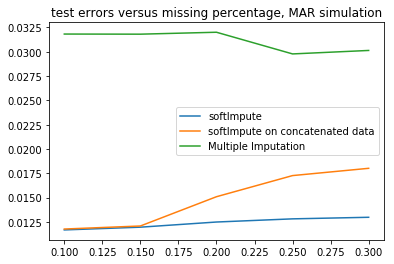

In [141]:
# plot for test_error, test_error_concat w.r.t missing percentage, MAR simulation
plt.plot([0.1, 0.15, 0.2, 0.25,0.3], MAR_errs, [0.1, 0.15, 0.2, 0.25,0.3],MAR_con_errs, \
        [0.1, 0.15, 0.2, 0.25,0.3],MAR_MI_errs)
plt.title('test errors versus missing percentage, MAR simulation')
plt.legend(['softImpute', 'softImpute on concatenated data','Multiple Imputation'], loc='best')
plt.show()

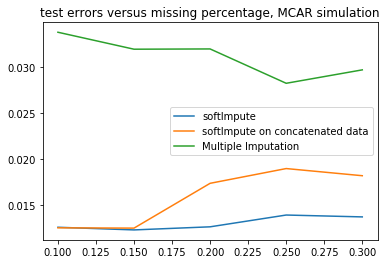

In [142]:
# plot for test_error, test_error_concat w.r.t missing percentage, MCAR simulation
plt.plot([0.1, 0.15, 0.2, 0.25,0.3], MCAR_errs, [0.1, 0.15, 0.2, 0.25,0.3],MCAR_con_errs,\
        [0.1, 0.15, 0.2, 0.25,0.3],MCAR_MI_errs)
plt.title('test errors versus missing percentage, MCAR simulation')
plt.legend(['softImpute', 'softImpute on concatenated data','Multiple Imputation'], loc='best')
plt.show()

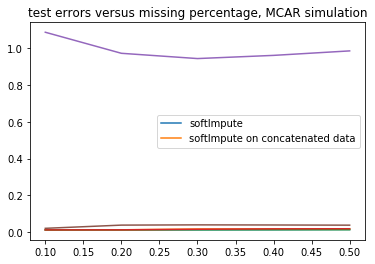

In [51]:
# plot for all three test_error, test_error_concat w.r.t missing percentage, MCAR simulation
plt.plot([0.1, 0.2, 0.3, 0.4,0.5], MCAR_errs, [0.1, 0.2, 0.3, 0.4,0.5],MCAR_con_errs)
plt.plot([0.1, 0.2, 0.3, 0.4,0.5], MAR_errs, [0.1, 0.2, 0.3, 0.4,0.5],MAR_con_errs)
plt.plot([0.1, 0.2, 0.3, 0.4,0.5], NMAR_errs, [0.1, 0.2, 0.3, 0.4,0.5],NMAR_con_errs)
plt.title('test errors versus missing percentage, MCAR simulation')
plt.legend(['softImpute', 'softImpute on concatenated data'], loc='best')
plt.show()

- For NMAR: concatenating mask has better performance for all different missing % (10% - 50%)
- For MAR: similar
- For MCAR: concatenating mask makes it worse (added extra noise without valuable information)